# Import Libraries

In [1]:
import json
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns

# Load Data

In [2]:
data_path = 'data.json' # Accidently removed part of this function when I was cleaning up the code. Now restored. Sorry =/
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

X, y = load_data(data_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

FileNotFoundError: ignored

<AxesSubplot:xlabel='Instruments', ylabel='count'>

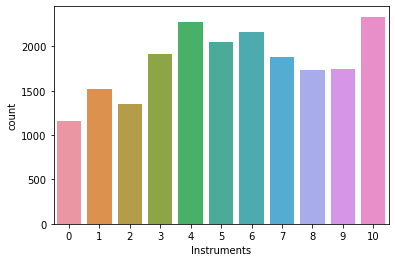

In [ ]:
y_df = pd.DataFrame(y, columns = ['Instruments'])
sns.countplot(x = "Instruments", data = y_df)

# Convolutional Neural Network

In [ ]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)

print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(17097, 87, 13)
(17097, 87, 13, 1)
(3018, 87, 13)
(3018, 87, 13, 1)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3)

cnn = keras.Sequential()

# Conv. layer 1
cnn.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])))
cnn.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'))
cnn.add(keras.layers.BatchNormalization())

# Conv. layer 2
cnn.add(keras.layers.Conv2D(64, (3,3), activation = 'relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = 'same'))
cnn.add(keras.layers.BatchNormalization())

# Conv. layer 3
cnn.add(keras.layers.Conv2D(128, (5,5), activation = 'relu'))
cnn.add(keras.layers.MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same'))
cnn.add(keras.layers.BatchNormalization())

# Fully Connected
cnn.add(keras.layers.Flatten())
'''
cnn.add(keras.layers.Dense(256, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.20))
'''
cnn.add(keras.layers.Dense(128, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.20))

cnn.add(keras.layers.Dense(64, activation = 'relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(Dropout(rate = 0.15))

cnn.add(keras.layers.Dense(11, activation = 'softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 85, 11, 32)        320       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 85, 11, 32)        0         
_________________________________________________________________
batch_normalization_118 (Bat (None, 85, 11, 32)        128       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 83, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 42, 5, 64)         0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 42, 5, 64)         256       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 38, 1, 128)      

Epoch 1/25
268/268 [==============================] - 43s 161ms/step - loss: 2.2128 - accuracy: 0.2831 - val_loss: 1.8346 - val_accuracy: 0.3900
Epoch 2/25
268/268 [==============================] - 43s 159ms/step - loss: 1.8557 - accuracy: 0.3770 - val_loss: 1.6832 - val_accuracy: 0.4410
Epoch 3/25
268/268 [==============================] - 42s 159ms/step - loss: 1.7340 - accuracy: 0.4235 - val_loss: 1.6314 - val_accuracy: 0.4672
Epoch 4/25
268/268 [==============================] - 42s 158ms/step - loss: 1.6430 - accuracy: 0.4507 - val_loss: 1.5528 - val_accuracy: 0.4864
Epoch 5/25
268/268 [==============================] - 43s 162ms/step - loss: 1.5600 - accuracy: 0.4755 - val_loss: 1.5383 - val_accuracy: 0.4964
Epoch 6/25
268/268 [==============================] - 46s 172ms/step - loss: 1.4989 - accuracy: 0.4999 - val_loss: 1.5212 - val_accuracy: 0.4891
Epoch 7/25
268/268 [==============================] - 44s 162ms/step - loss: 1.4358 - accuracy: 0.5192 - val_loss: 1.4744 - val_ac

<AxesSubplot:>

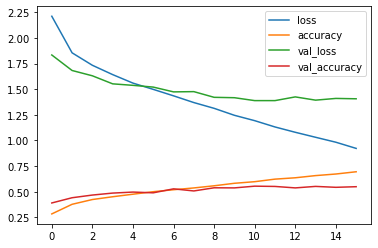

In [ ]:
cnn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [early_stop], batch_size = 64, epochs = 25)
loss_history = pd.DataFrame(cnn.history.history)
loss_history.plot()

In [ ]:
predict = cnn.predict_classes(X_test)
print(classification_report(y_test,predict))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       185
           1       0.53      0.48      0.51       237
           2       0.45      0.47      0.46       203
           3       0.56      0.54      0.55       277
           4       0.53      0.61      0.57       333
           5       0.64      0.55      0.59       315
           6       0.53      0.68      0.59       317
           7       0.42      0.43      0.43       276
           8       0.51      0.57      0.54       258
           9       0.48      0.48      0.48       261
          10       0.82      0.55      0.66       356

    accuracy    

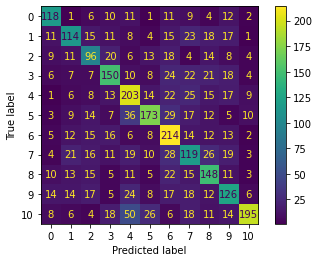

In [ ]:
cm = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Multi Layer Perceptron

In [ ]:
mlp = keras.Sequential()

# input layer
mlp.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))

# 1st dense layer
mlp.add(keras.layers.Dense(516, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))

mlp.add(Dropout(rate = 0.10))

# 2nd dense layer
mlp.add(keras.layers.Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))

mlp.add(Dropout(rate = 0.10))
    
# 3rd dense layer
mlp.add(keras.layers.Dense(128, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
mlp.add(Dropout(rate = 0.10))

# output layer
mlp.add(keras.layers.Dense(11, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mlp.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 1131)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 516)               584112    
_________________________________________________________________
dropout_73 (Dropout)         (None, 516)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 256)               132352    
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_75 (Dropout)         (None, 128)             

Epoch 1/150
535/535 [==============================] - 4s 8ms/step - loss: 9.8424 - accuracy: 0.1419 - val_loss: 3.5352 - val_accuracy: 0.1256
Epoch 2/150
535/535 [==============================] - 4s 7ms/step - loss: 3.6436 - accuracy: 0.1249 - val_loss: 3.5084 - val_accuracy: 0.1378
Epoch 3/150
535/535 [==============================] - 4s 7ms/step - loss: 3.5213 - accuracy: 0.1513 - val_loss: 3.4523 - val_accuracy: 0.1537
Epoch 4/150
535/535 [==============================] - 4s 7ms/step - loss: 3.4601 - accuracy: 0.1624 - val_loss: 3.4086 - val_accuracy: 0.1620
Epoch 5/150
535/535 [==============================] - 4s 7ms/step - loss: 3.3990 - accuracy: 0.1792 - val_loss: 3.3271 - val_accuracy: 0.1912
Epoch 6/150
535/535 [==============================] - 4s 7ms/step - loss: 3.3211 - accuracy: 0.1951 - val_loss: 3.2232 - val_accuracy: 0.2170
Epoch 7/150
535/535 [==============================] - 4s 7ms/step - loss: 3.2377 - accuracy: 0.2099 - val_loss: 3.1724 - val_accuracy: 0.2180

<AxesSubplot:>

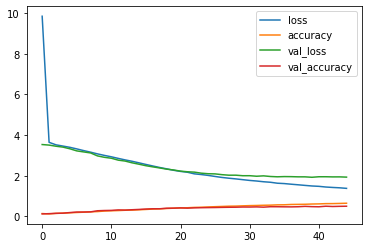

In [ ]:
mlp.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks = [early_stop], batch_size=32, epochs=150)
loss_history = pd.DataFrame(mlp.history.history)
loss_history.plot()

In [ ]:
predict = mlp.predict_classes(X_test)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52       185
           1       0.61      0.38      0.47       237
           2       0.42      0.33      0.37       203
           3       0.48      0.47      0.48       277
           4       0.53      0.57      0.55       333
           5       0.50      0.65      0.57       315
           6       0.52      0.51      0.51       317
           7       0.37      0.25      0.30       276
           8       0.43      0.62      0.51       258
           9       0.50      0.52      0.51       261
          10       0.61      0.65      0.62       356

    accuracy                           0.51      3018
   macro avg       0.51      0.49      0.49      3018
weighted avg       0.51      0.51      0.50      3018



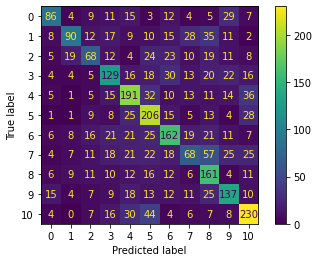

In [ ]:
cm = confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(cm).plot()